Przygotowanie danych zakończone. Pierwsze 5 wierszy:
            Count
Date             
2020-01-01    939
2020-01-02   3426
2020-01-03   3167
2020-01-04   2472
2020-01-05   1554
Zakres dat: 2020-01-01 do 2020-12-31

--- ANALIZA PROCESU ---
--- Trenowanie modelu ---
 Wykryto 10 dni świątecznych.
--- Model dopasowany ---
Generowanie prognozy na 365 dni
--- Ocena jakości: Dopasowanie Historyczne (2020) ---
MAE (Średni Błąd Absolutny):       196.17
RMSE (Błąd Średniokwadratowy):     287.78
MAPE (Średni Błąd Procentowy):     8.55%
R2 (Współczynnik Determinacji):    0.7745
----------------------------------------


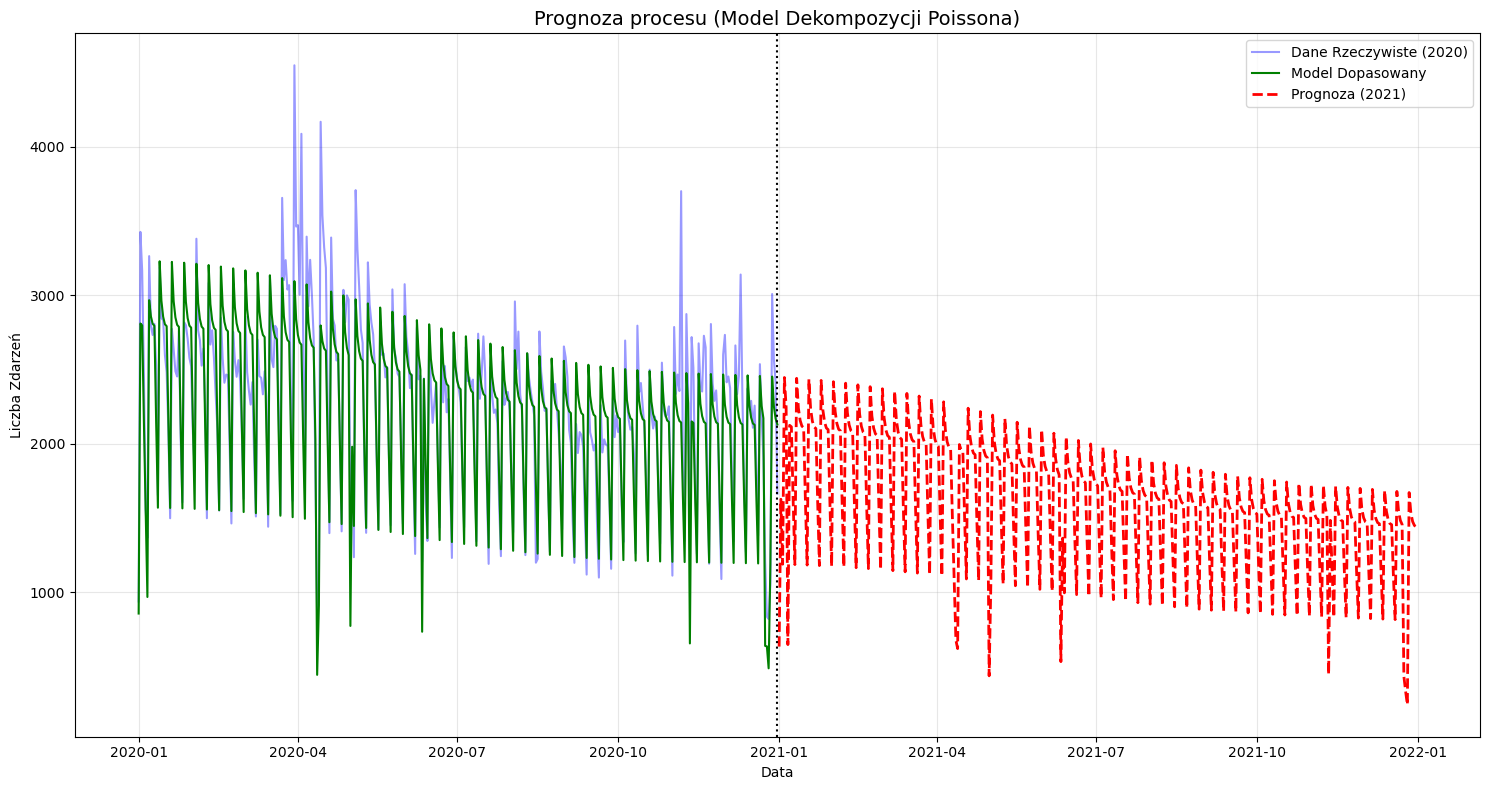

In [1]:
# ============================================================================
# 1. WCZYTANIE DANYCH
# ============================================================================
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Ignorowanie ostrzeżeń dla czytelności
warnings.filterwarnings("ignore")

def __iter__(self): return 0

# Standardowa onfiguracja klienta COS, żeby wczytać dane
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='sJG23hIBe5sXXty1D9WD5PMWCPTK_d3V1FM4fCRzlnNN',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'lab50-donotdelete-pr-njlp8ctbnbpmqt'
object_key = 'kolokwium-dane-0912.csv'

# Pobranie pliku
body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Wczytanie DataFrame, zauważamy, że separatorem jest średnik
df = pd.read_csv(body, sep=';')

# Zmiana nazw kolumn i konwersja typów
df.columns = ['Date', 'Count']
df['Date'] = pd.to_datetime(df['Date'])

# Ustawienie kolumny 'Date' jako indeks
df = df.set_index('Date')
df = df.sort_index()

# Weryfikacja danych
if (df['Count'] < 0).any():
    print("UWAGA: Dane zawierają ujemne wartości.")

print("Przygotowanie danych zakończone. Pierwsze 5 wierszy:")
print(df.head())
print(f"Zakres dat: {df.index.min().date()} do {df.index.max().date()}")


# ============================================================================
# 2. DEFINICJA KLASY DO ANALIZY I PROGNOZOWANIA
# ============================================================================

class PoissonProcessDecomposer:
    """
    Klasa do dekompozycji i prognozowania szeregu czasowego (Proces Poissona/Zliczeniowy).
    Modeluje: Trend, Sezonowość Tygodniową, Sezonowość Roczną i Efekt Świąt.
    """
    
    def __init__(self, df, date_col='Date', value_col='Count'):
        # Tworzymy kopię, aby nie modyfikować oryginału w niekontrolowany sposób
        self.df = df.copy()
        
        # Obsługa sytuacji, gdy data jest w indeksie
        if date_col not in self.df.columns and self.df.index.name == date_col:
            self.df = self.df.reset_index()
            
        self.date_col = date_col
        self.value_col = value_col
        
        # Przygotowanie danych (sortowanie, typy)
        self.df[date_col] = pd.to_datetime(self.df[date_col])
        self.df = self.df.sort_values(date_col).reset_index(drop=True)
        
        # Kolumny pomocnicze
        self.df['time_index'] = np.arange(len(self.df))
        self.df['day_of_week'] = self.df[date_col].dt.dayofweek
        self.df['day_of_year'] = self.df[date_col].dt.dayofyear
        
        # Słowniki na parametry modelu
        self.components = {}
        self.trend_params = {}
        self.weekly_params = {}
        self.yearly_params = {}
        self.holiday_params = {}
        self.lambda_estimated = None

# Funkcja do estymowania trendu
    
    def estimate_trend(self, method='linear'):
        """Estymuje trend liniowy."""
        X = self.df[['time_index']].values
        y = self.df[self.value_col].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        self.trend_params = {
            'intercept': model.intercept_,
            'slope': model.coef_[0]
        }
        self.components['trend'] = model.predict(X)

# Funkcja do estymowania sezonowości tygodniowej
        
    def estimate_weekly_seasonality(self):
        """Estymuje wzorzec tygodniowy (np. spadki w weekendy)."""
        if 'trend' not in self.components: self.estimate_trend()
        
        # Usuwamy trend
        detrended = self.df[self.value_col] / self.components['trend']
        
        # Średnia dla każdego dnia tygodnia
        weekly_means = detrended.groupby(self.df['day_of_week']).mean()
        overall_mean = weekly_means.mean()
        
        # Normalizacja
        weekly_pattern_norm = weekly_means / overall_mean
        self.weekly_params = weekly_pattern_norm.to_dict()
        
        self.components['week_pattern'] = self.df['day_of_week'].map(self.weekly_params).values

# Funkcja do estymowania sezonowości rocznej
    
    def estimate_yearly_seasonality(self):
        """Estymuje sezonowość roczną metodą Fouriera."""
        detrended = self.df[self.value_col].copy()
        if 'trend' in self.components: detrended /= self.components['trend']
        if 'week_pattern' in self.components: detrended /= self.components['week_pattern']
        
        doy = self.df['day_of_year'].values
        # Jedna harmoniczna (sin + cos)
        X = np.column_stack([
            np.ones_like(doy),
            np.sin(2 * np.pi * doy / 365),
            np.cos(2 * np.pi * doy / 365)
        ])
        
        coeffs = np.linalg.lstsq(X, detrended.values, rcond=None)[0]
        self.yearly_params['coefficients'] = coeffs
        
        year_pattern = X @ coeffs
        year_pattern /= year_pattern.mean()
        self.components['year_pattern'] = year_pattern

# Funkcja do wykrywania świąt w naszych danych
        
    def detect_holidays(self, threshold=0.6):
        """Wykrywa dni o nietypowo niskiej aktywności (święta)."""
        residual = self.df[self.value_col].copy()
        for comp in ['trend', 'week_pattern', 'year_pattern']:
            if comp in self.components: residual /= self.components[comp]
            
        median_res = residual.median()
        # Dni, gdzie wartość jest mniejsza niż 60% mediany
        is_holiday = residual < (median_res * threshold)
        
        holiday_effect_val = 0.3 # Zakładamy spadek do 30% normy
        self.components['holiday_effect'] = np.where(is_holiday, holiday_effect_val, 1.0)
        
        holiday_dates = self.df[is_holiday][self.date_col]
        # Zapamiętujemy (miesiąc, dzień)
        self.holiday_params = {
            'dates_md': set(zip(holiday_dates.dt.month, holiday_dates.dt.day)),
            'effect': holiday_effect_val
        }
        print(f" Wykryto {len(holiday_dates)} dni świątecznych.")

# Dopasowanie estymacji do naszych danych
    
    def fit(self):
        """Trenuje model na dostępnych danych."""
        print("--- Trenowanie modelu ---")
        self.estimate_trend()
        self.estimate_weekly_seasonality()
        self.estimate_yearly_seasonality()
        self.detect_holidays()
        
        # Złożenie modelu (iloczyn komponentów)
        self.lambda_estimated = (
            self.components['trend'] *
            self.components['week_pattern'] *
            self.components['year_pattern'] *
            self.components['holiday_effect']
        )
        self.df['lambda_estimated'] = self.lambda_estimated
        print("--- Model dopasowany ---")
        return self

# Funkcja do wykonania prognozy na kolejny rok
        
    def predict_future(self, steps=365):
        """Generuje prognozę na 'steps' dni w przód."""
        last_date = self.df[self.date_col].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='D')
        
        # 1. Trend
        last_idx = self.df['time_index'].max()
        future_idx = np.arange(last_idx + 1, last_idx + 1 + steps)
        future_trend = self.trend_params['intercept'] + self.trend_params['slope'] * future_idx
        future_trend = np.maximum(future_trend, 0)
        
        # 2. Tygodniówka
        future_dow = future_dates.dayofweek
        future_weekly = future_dow.map(self.weekly_params).fillna(1.0).values
        
        # 3. Roczna (Fourier)
        future_doy = future_dates.dayofyear
        X_fut = np.column_stack([
            np.ones_like(future_doy),
            np.sin(2 * np.pi * future_doy / 365),
            np.cos(2 * np.pi * future_doy / 365)
        ])
        coeffs = self.yearly_params['coefficients']
        future_yearly = X_fut @ coeffs
        future_yearly /= future_yearly.mean()
        
        # 4. Święta
        future_holidays = []
        known_holidays = self.holiday_params.get('dates_md', set())
        eff = self.holiday_params.get('effect', 1.0)
        
        for d in future_dates:
            if (d.month, d.day) in known_holidays:
                future_holidays.append(eff)
            else:
                future_holidays.append(1.0)
        future_holidays = np.array(future_holidays)
        
        # Wynik
        lambda_future = future_trend * future_weekly * future_yearly * future_holidays
        return pd.Series(lambda_future, index=future_dates, name='Forecast')


# ============================================================================
# 3. WYKONANIE ANALIZY
# ============================================================================

print("\n--- ANALIZA PROCESU ---")

# Inicjalizacja i trening
decomposer = PoissonProcessDecomposer(df)
decomposer.fit()

# ============================================================================
# 4. GENEROWANIE PROGNOZY NA KOLEJNY ROK (2021)
# ============================================================================
print("Generowanie prognozy na 365 dni")

# Wywołujemy metodę, którą zdefiniowaliśmy w klasie
forecast_2021 = decomposer.predict_future(steps=365)

# Pobieramy dopasowane dane historyczne z obiektu (żeby mieć dostęp do lambda_estimated)
# Ustawiamy indeks na Date, aby łatwo rysować wykresy

df_fitted = decomposer.df.set_index(decomposer.date_col)

# ============================================================================
# 5. FUNKCJA OCENIAJĄCA JAKOŚĆ PROGNOZY
# ============================================================================

# Tutaj chcemy ocenić jakość naszej prognozy za pomocą parametrów: MAE, RMSE, MAPE i R2.

def evaluate_quality(y_true, y_pred, set_name="Zbiór"):
    """
    Oblicza metryki: MAE, RMSE, MAPE, R2.
    """
    # Wyrównanie indeksów (bierzemy tylko wspólne daty)
    
    common_idx = y_true.index.intersection(y_pred.index)
    if len(common_idx) == 0:
        print(f"Brak wspólnych danych dla: {set_name}")
        return {}
    
    true_vals = y_true.loc[common_idx]
    pred_vals = y_pred.loc[common_idx]
    
    mae = mean_absolute_error(true_vals, pred_vals)
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    
    # MAPE z zabezpieczeniem przed dzieleniem przez 0
    
    true_safe = np.where(true_vals == 0, 1e-6, true_vals)
    mape = np.mean(np.abs((true_vals - pred_vals) / true_safe)) * 100
    
    r2 = r2_score(true_vals, pred_vals)
    
    print(f"--- Ocena jakości: {set_name} ---")
    print(f"MAE (Średni Błąd Absolutny):       {mae:.2f}")
    print(f"RMSE (Błąd Średniokwadratowy):     {rmse:.2f}")
    print(f"MAPE (Średni Błąd Procentowy):     {mape:.2f}%")
    print(f"R2 (Współczynnik Determinacji):    {r2:.4f}")
    print("-" * 40)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

# Sprawdzamy jakość dopasowania modelu do danych historycznych (In-Sample)
# Ponieważ nie mamy prawdziwych danych na 2021, to najlepsza ocena jaką mamy teraz.

evaluate_quality(df_fitted['Count'], df_fitted['lambda_estimated'], set_name="Dopasowanie Historyczne (2020)")

# ============================================================================
# 6. WIZUALIZACJA
# ============================================================================

plt.figure(figsize=(15, 8))


# 1. Dane rzeczywiste (kropki lub cienka linia)
plt.plot(df_fitted.index, df_fitted['Count'], 
         label='Dane Rzeczywiste (2020)', color='blue', alpha=0.4)

# 2. Model dopasowany do historii (linia ciągła)

plt.plot(df_fitted.index, df_fitted['lambda_estimated'], 
         label='Model Dopasowany', color='green', linewidth=1.5)

# 3. Prognoza na przyszłość (linia przerywana/czerwona)

plt.plot(forecast_2021.index, forecast_2021, 
         label='Prognoza (2021)', color='red', linestyle='--', linewidth=2)

plt.title('Prognoza procesu (Model Dekompozycji Poissona)', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Liczba Zdarzeń')
plt.legend()
plt.grid(True, alpha=0.3)

# Dodanie pionowej linii oddzielającej historię od prognozy

last_hist_date = df_fitted.index.max()
plt.axvline(x=last_hist_date, color='black', linestyle=':', label='Koniec danych')

plt.tight_layout()
plt.show()

# Analizujemy wyniki funkji, która ocenia jakość prognozy

# MAE (Średni Błąd Absolutny):       196.17
# RMSE (Błąd Średniokwadratowy):     287.78
# MAPE (Średni Błąd Procentowy):     8.55%
# R2 (Współczynnik Determinacji):    0.7745

# Wyniki oznaczają, że dopasowanie jest dosyć dobre, co sugeruje, że dane mogą opisywać proces Poissona.